In [32]:
import os

import psycopg2 as psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "clear_user_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ['MLFLOW_S3_ENDPOINT_URL']='https://storage.yandexcloud.net'
os.environ['AWS_BUCKET_NAME']=os.environ.get("S3_BUCKET_NAME")

EXPERIMENT_NAME = "eda_binary_and_float"
RUN_NAME = "eda"

ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [33]:
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.environ.get("DB_DESTINATION_HOST"), 
    "port": os.environ.get("DB_DESTINATION_PORT"),
    "dbname": os.environ.get("DB_DESTINATION_NAME"),
    "user": os.environ.get("DB_DESTINATION_USER"),
    "password": os.environ.get("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

TABLE_NAME = "clean_users_churn"

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,13,8091-TTVAX,2015-04-01,NaT,One year,No,Credit card (automatic),100.35,5681.1,Fiber optic,No,No,Yes,No,Yes,Yes,Male,0,Yes,No,Yes,0
1,14,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,0,No,No,Yes,1


In [34]:
df.replace({'Yes': 1,'No':0},inplace=True)
df.head(2)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,13,8091-TTVAX,2015-04-01,NaT,One year,0,Credit card (automatic),100.35,5681.1,Fiber optic,0,0,1,0,1,1,Male,0,1,0,1,0
1,14,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,1,Bank transfer (automatic),103.70,5036.3,Fiber optic,0,1,1,0,1,1,Male,0,0,0,1,1


/tmp/ipykernel_2306/397698353.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(labels = df[x].unique(), rotation = 45)


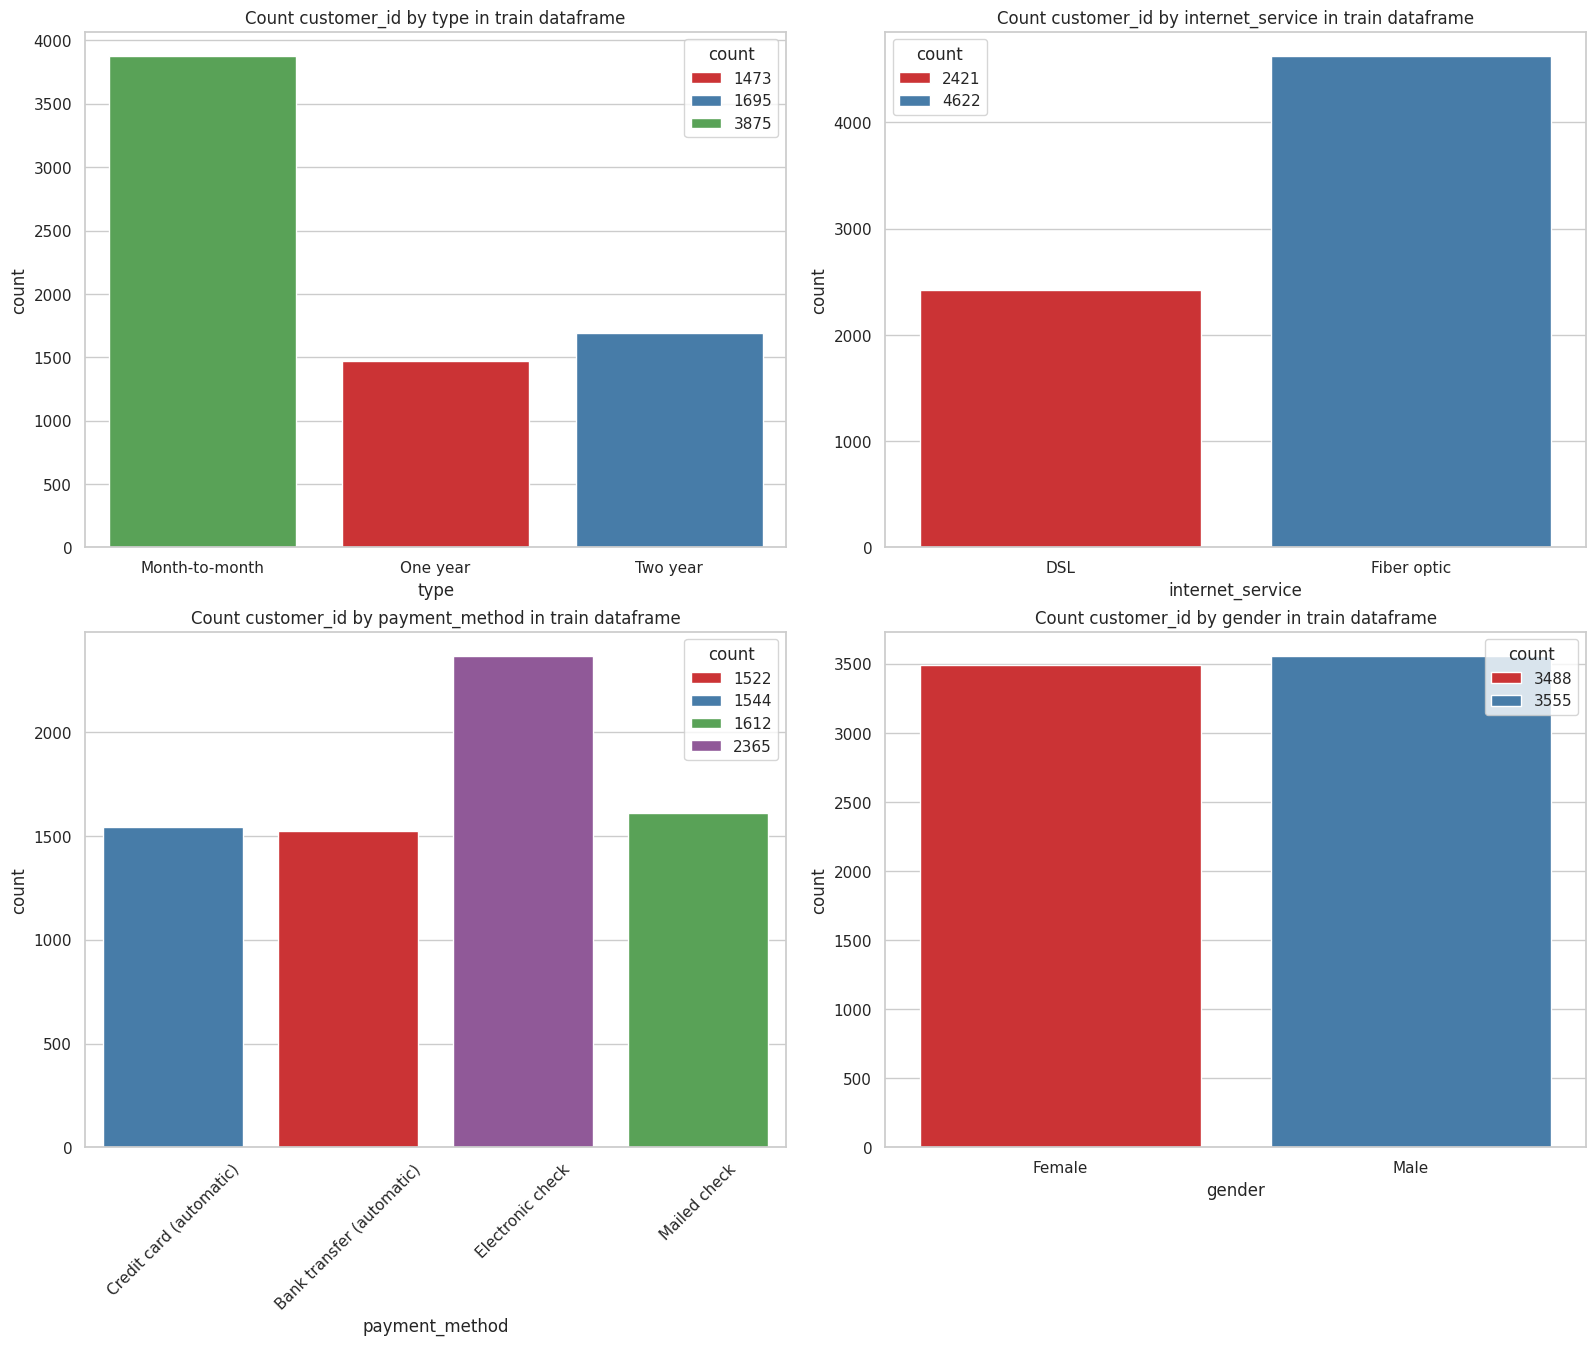

In [45]:
fig, axs = plt.subplots(2,2)
fig.set_size_inches(16.5,12.5, forward=True)
fig.tight_layout(pad=3)

x = "type"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({x: stat}).reset_index()
agg_df.columns = agg_df.columns[1]
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax = axs[0,0],
    palette='Set1',
    hue=stat[0],
)
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
agg_df = df.groupby(x).agg({x: stat}).reset_index()
agg_df.columns = agg_df.columns[1]
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax = axs[1,0],
    palette='Set1',
    hue=stat[0],
)
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(labels = df[x].unique(), rotation = 45)

x = "internet_service"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({x: stat}).reset_index()
agg_df.columns = agg_df.columns[1]
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax = axs[0,1],
    palette='Set1',
    hue=stat[0],
)
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "gender"
y = "customer_id"
stat = ["count"]
agg_df = df.groupby(x).agg({x: stat}).reset_index()
agg_df.columns = agg_df.columns[1]
sns.barplot(
    data=agg_df,
    x=x,
    y=stat[0],
    ax = axs[1,1],
    palette='Set1',
    hue=stat[0],
)
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [46]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ['count']

df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,0,0,0,0,0,0,0,0,0,1017
3,0,0,0,0,0,0,0,1,1,591
2,0,0,0,0,0,0,0,1,0,251
1,0,0,0,0,0,0,0,0,1,151
4,0,0,0,0,0,0,1,0,0,126
106,0,1,0,0,0,0,0,0,0,105
414,1,1,1,1,1,1,0,1,1,103
8,0,0,0,0,0,1,0,0,0,90
15,0,0,0,0,1,0,0,0,0,86
214,1,0,0,0,0,0,0,0,0,83


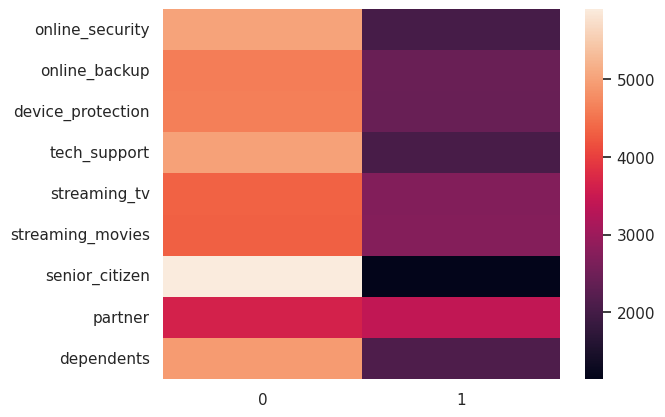

In [47]:
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)
    
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

/tmp/ipykernel_2306/3544899054.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[charges_columns].dropna(inplace=True)


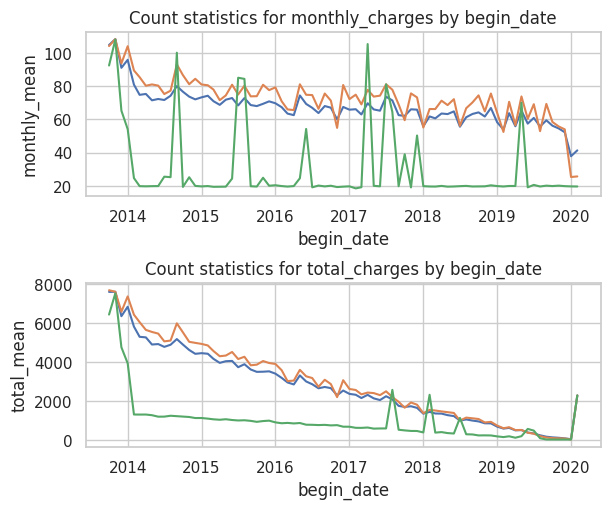

In [58]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = df[[x] + [charges_columns[1]]].groupby([x]).agg(stats).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=2.5)
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')

sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')

axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

In [61]:
target_agg.columns

Index(['target', 'count'], dtype='object')

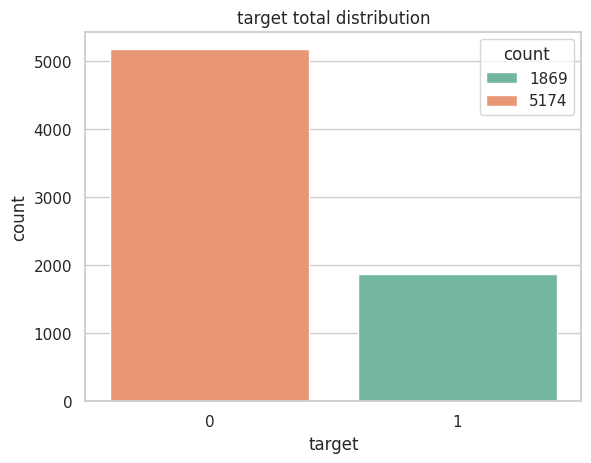

In [64]:
# установка названия колонки для агрегации
x = "target"

# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.barplot(
    data=target_agg,
    x='target',
    y='count',
    hue='count',
    palette='Set2'
)

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

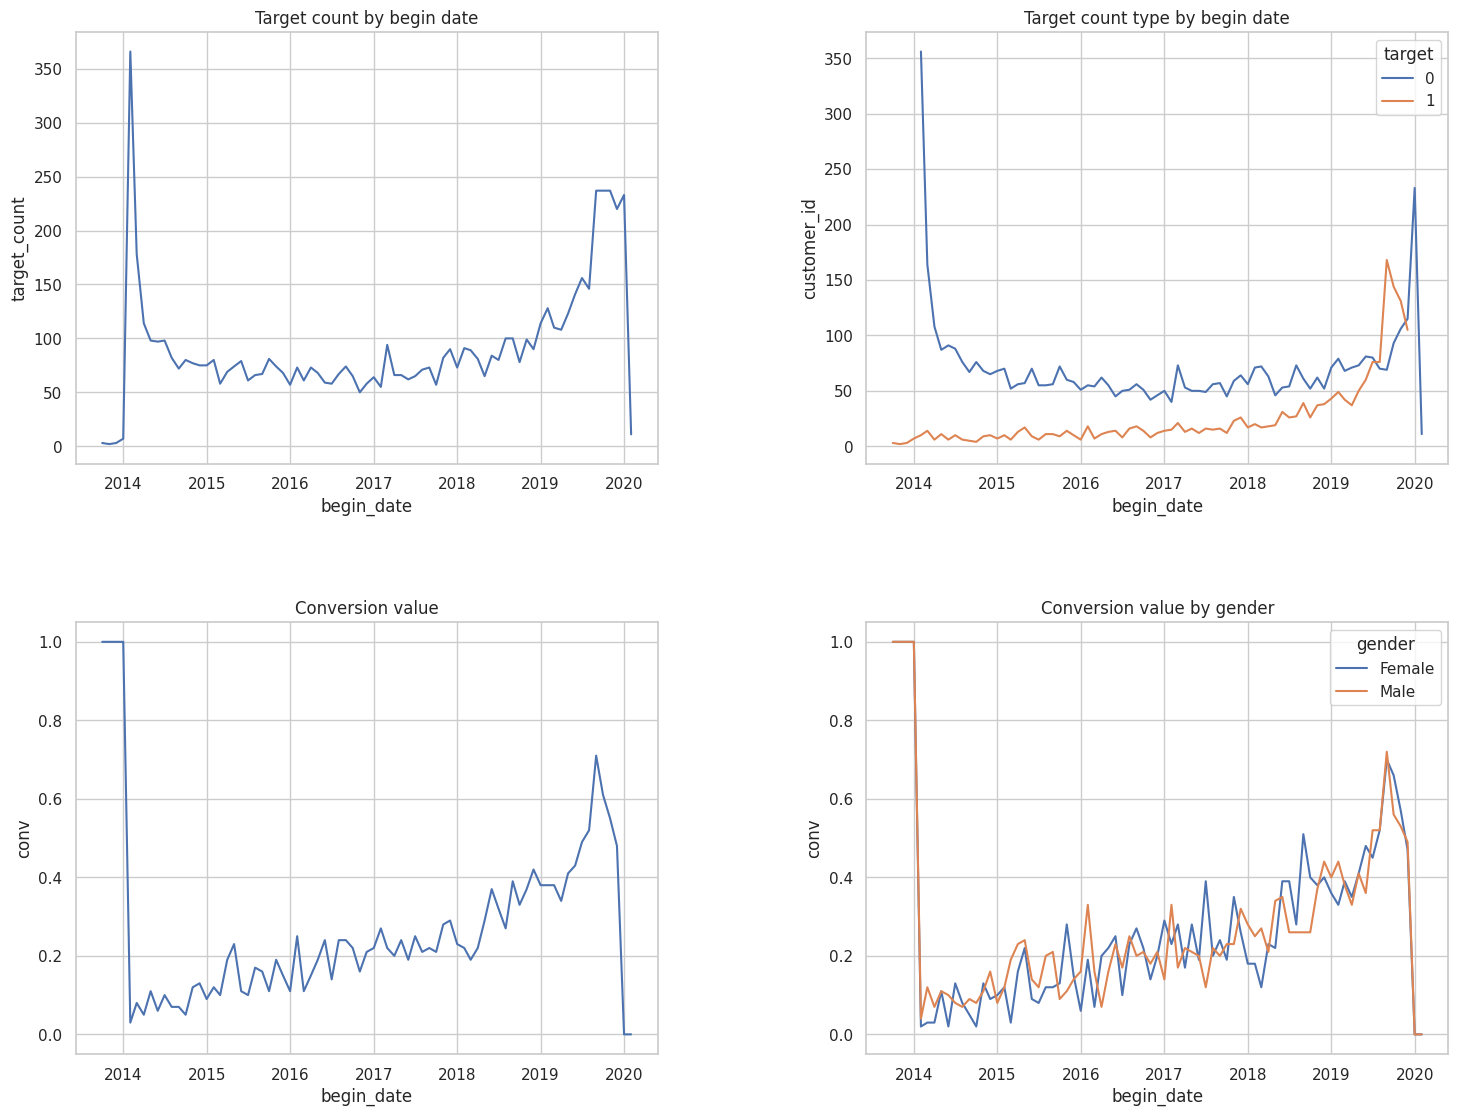

In [65]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, 'gender']].groupby([x, 'gender'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] =  (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
# ваш код здесь #
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

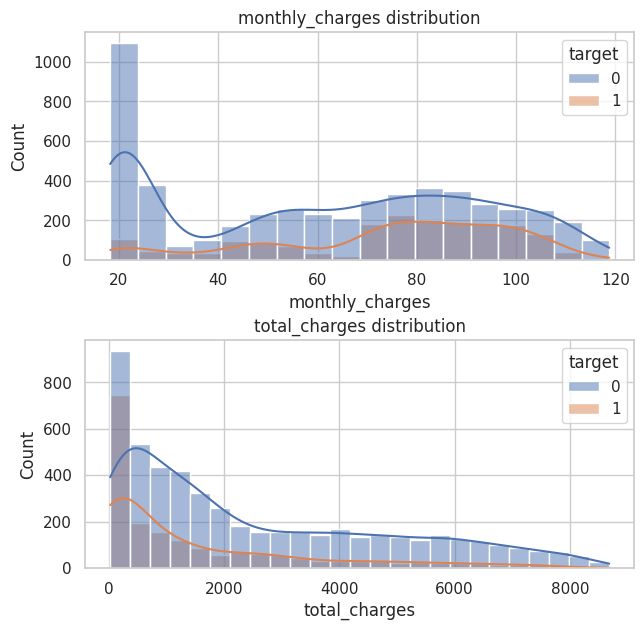

In [66]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
sns.histplot(
    data=df, 
    x=charges[0], 
    hue=target, 
    kde=True, 
    ax=axs[0]
)
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
# ваш код здесь #
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
sns.histplot(
    data=df, 
    x=charges[1], 
    hue=target, 
    kde=True, 
    ax=axs[1]
)
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [69]:

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
if not experiment_id:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [70]:
run_id

'38488ac8327f487faeb7016be809a784'